In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import os
import numpy as np

In [26]:
df_reviews_raw = pd.read_parquet("C:\SourceCode\sentiment_amazon_review\dataset\sample_amazon_product_review_data_20240627_152732.parquet")

In [27]:
column_types = df_reviews_raw.dtypes
print(column_types)

asin                  object
helpful_vote           int32
parent_asin           object
rating               float64
text                  object
timestamp             object
title                 object
user_id               object
verified_purchase       bool
category              object
has_image               bool
dtype: object


In [28]:
print(f"Total number of raw records: {df_reviews_raw.shape[0]}")

# Remove records with null reviews
df_reviews_raw = df_reviews_raw[df_reviews_raw["text"].isna() == False]

print(f"Total number of records remaoned: {df_reviews_raw.shape[0]}")

Total number of raw records: 952804
Total number of records remaoned: 951769


In [29]:
df_reviews_raw.describe()

,helpful_vote,rating
count,951769.000000,951769.000000
mean,1.457020,3.017064
std,16.223503,1.424915
min,0.000000,1.000000
25%,0.000000,2.000000
50%,0.000000,3.000000
75%,1.000000,4.000000
max,6390.000000,5.000000


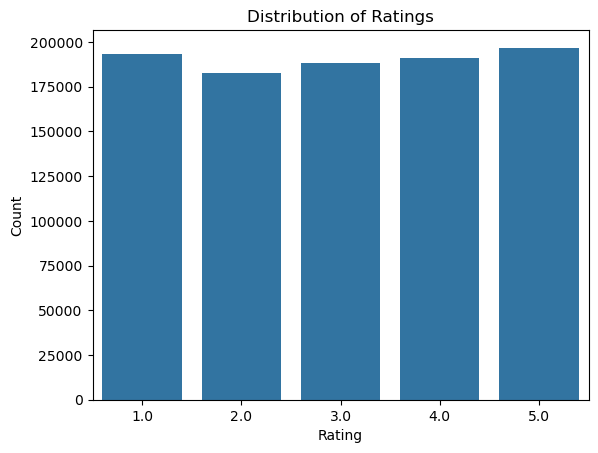

Mean rating: 3.02
Median rating: 3.0
Mode rating: 5.0


In [30]:
# 1. Distribution of ratings
plt.figure()
sns.countplot(x='rating', data=df_reviews_raw)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

mean_rating = df_reviews_raw['rating'].mean()
median_rating = df_reviews_raw['rating'].median()
mode_rating = df_reviews_raw['rating'].mode().values[0]
print(f"Mean rating: {mean_rating:.2f}")
print(f"Median rating: {median_rating}")
print(f"Mode rating: {mode_rating}")

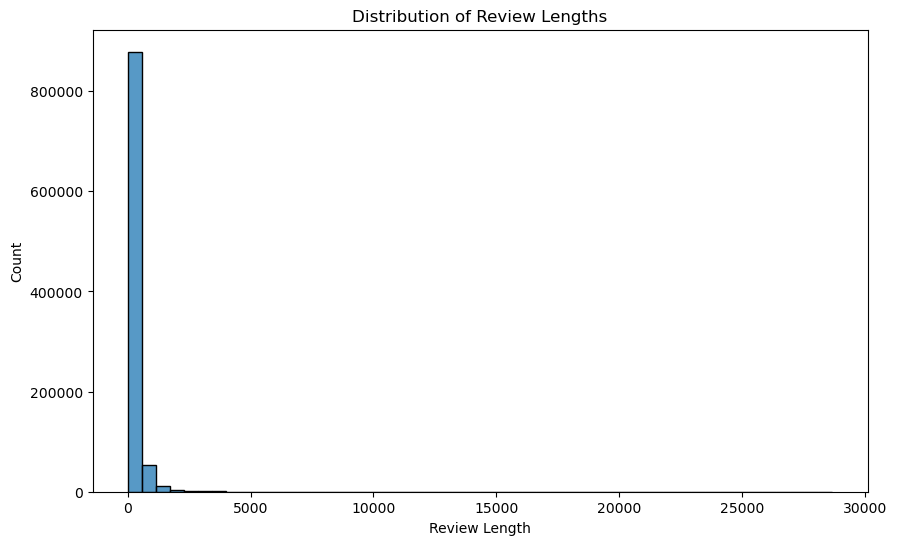

Correlation between review length and rating: -0.04


In [31]:
# 2. Review length analysis

df_reviews_raw['review_length'] = df_reviews_raw['text'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df_reviews_raw['review_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

correlation = df_reviews_raw['review_length'].corr(df_reviews_raw['rating'])
print(f"Correlation between review length and rating: {correlation:.2f}")

In [32]:
df_reviews_raw[df_reviews_raw['review_length'] > 5000]["text"]

9620      I got the 3 Bundles of Body Wave - 18 inch, 20...
65928     Reviewing the Flex-Duo version of this with in...
70681     Important note before I start my review: check...
102096    I write to you now as a true wordworking novic...
104625    Academy's 1/350 scale model of HMS Warspite is...
                                ...                        
947481    I normally hate vampires in anything. They're ...
947675    I am a huge fan of modern day card games and d...
949251    Since its debut last March, Nintendo 3DS owner...
951281    Very impressed with this keyboard, build quali...
951782    Once upon a time, a little company called Squa...
Name: text, Length: 395, dtype: object

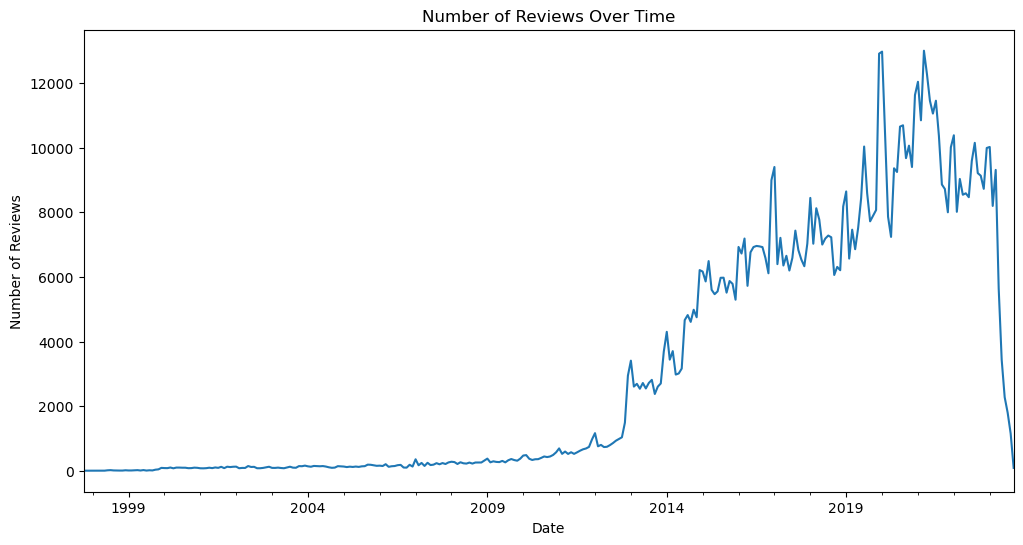

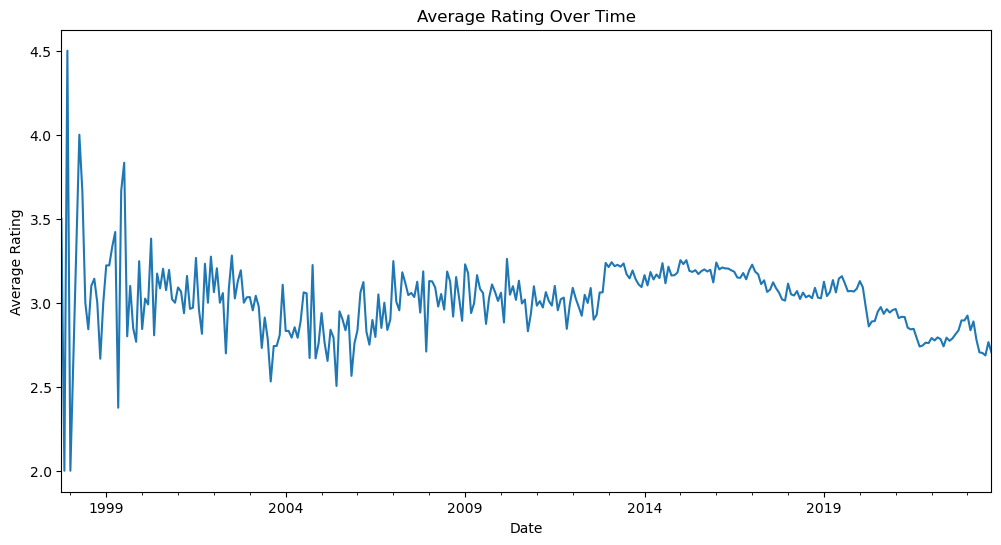

In [33]:
# 3. Time-based analysis

df_reviews_raw['timestamp'] = pd.to_datetime(df_reviews_raw['timestamp'].astype('int64'), unit='ms')
df_reviews_raw['date'] = df_reviews_raw['timestamp'].dt.date
df_reviews_raw['date'] = pd.to_datetime(df_reviews_raw['date'])
df_reviews_raw['review_year'] = df_reviews_raw['date'].dt.year
df_reviews_raw['review_month'] = df_reviews_raw['date'].dt.to_period('M')

reviews_over_time = df_reviews_raw.groupby('review_month').size()
plt.figure(figsize=(12, 6))
reviews_over_time.plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

avg_rating_over_time = df_reviews_raw.groupby('review_month')['rating'].mean()
plt.figure(figsize=(12, 6))
avg_rating_over_time.plot()
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()

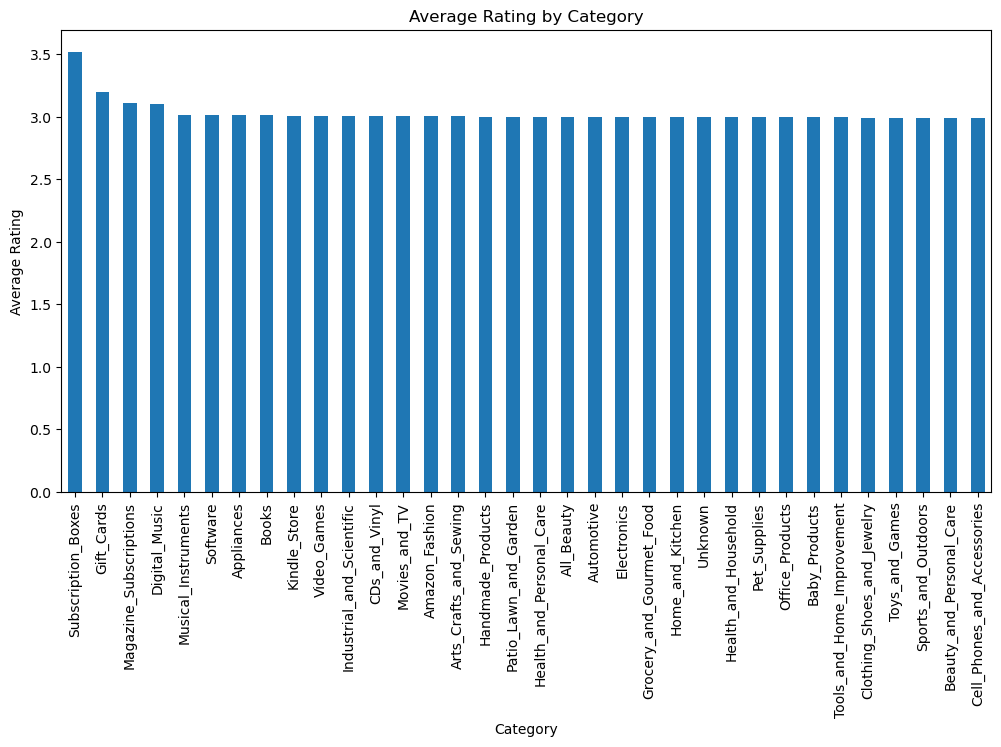

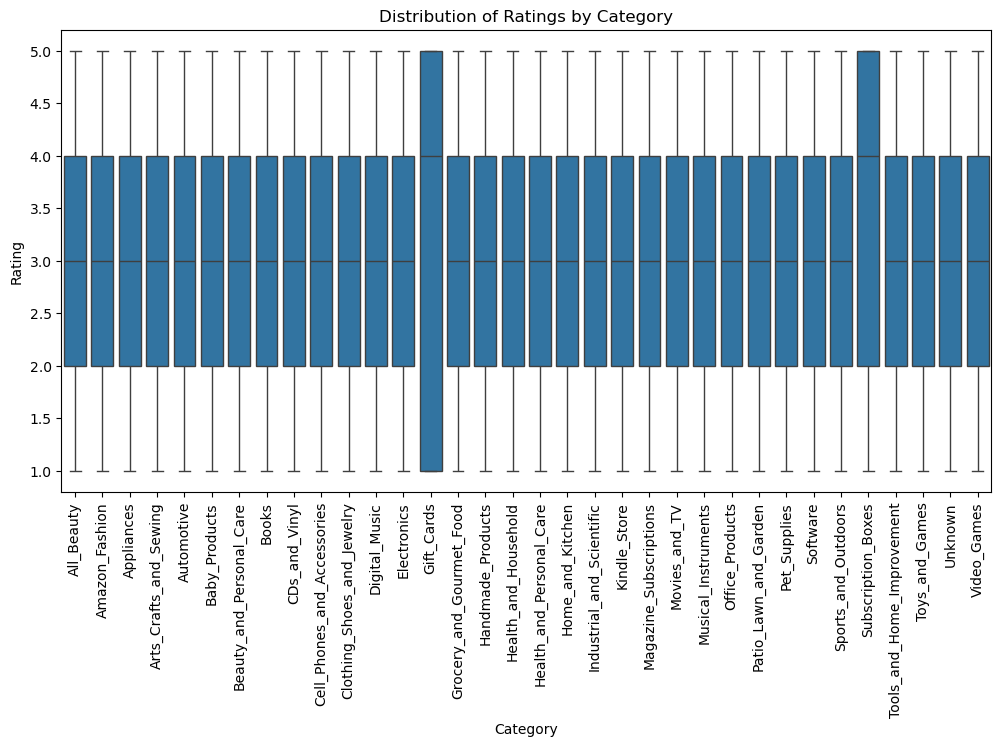

In [34]:
# 4. Category-based analysis

avg_rating_by_category = df_reviews_raw.groupby('category')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_rating_by_category.plot(kind='bar')
plt.title('Average Rating by Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

# Distribution of ratings within each category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='rating', data=df_reviews_raw)
plt.title('Distribution of Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

Average rating for verified purchases: 3.03
Average rating for non-verified purchases: 2.89
Percentage of verified purchases: 88.73%


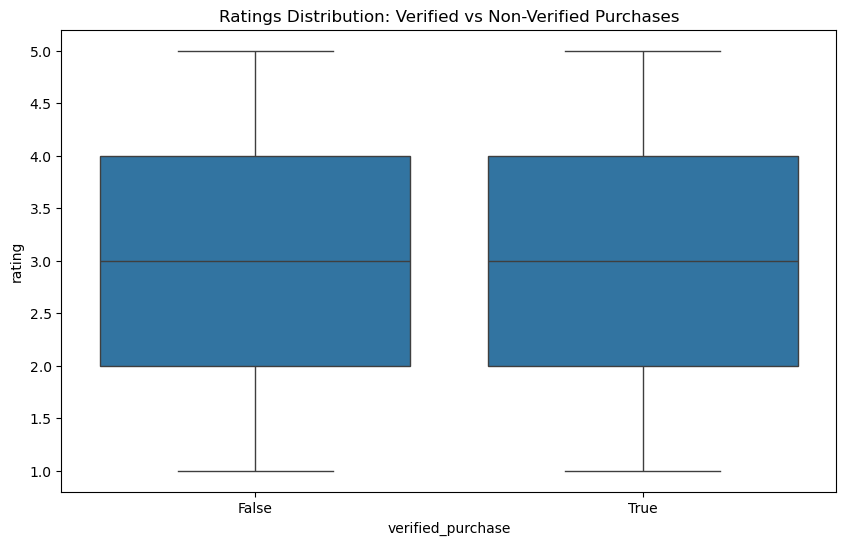

In [35]:
# 5. Verified purchase analysis

verified_avg = df_reviews_raw[df_reviews_raw['verified_purchase']]['rating'].mean()
non_verified_avg = df_reviews_raw[~df_reviews_raw['verified_purchase']]['rating'].mean()
print(f"Average rating for verified purchases: {verified_avg:.2f}")
print(f"Average rating for non-verified purchases: {non_verified_avg:.2f}")

verified_percentage = (df_reviews_raw['verified_purchase'].sum() / len(df_reviews_raw)) * 100
print(f"Percentage of verified purchases: {verified_percentage:.2f}%")

plt.figure(figsize=(10, 6))
sns.boxplot(x='verified_purchase', y='rating', data=df_reviews_raw)
plt.title('Ratings Distribution: Verified vs Non-Verified Purchases')
plt.show()

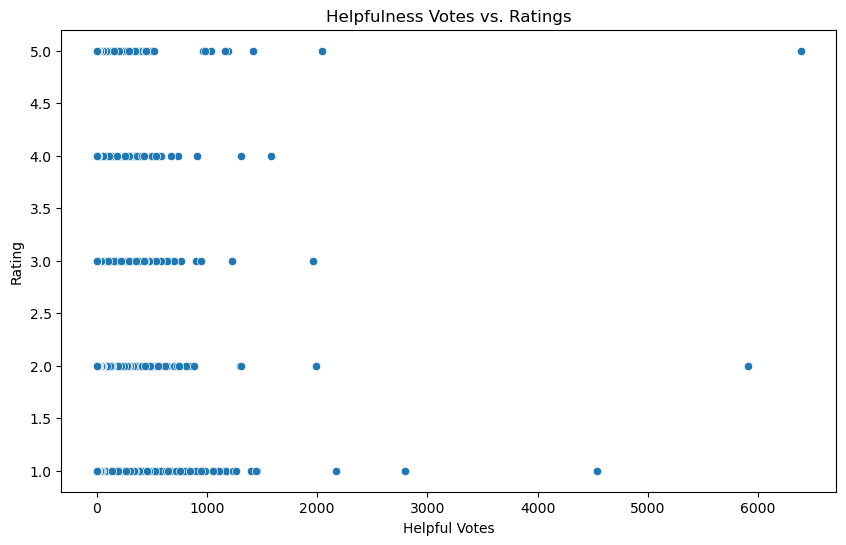

Correlation between helpful votes and rating: -0.03


In [36]:
# 6. Verified purchase analysis

plt.figure(figsize=(10, 6))
sns.scatterplot(x='helpful_vote', y='rating', data=df_reviews_raw)
plt.title('Helpfulness Votes vs. Ratings')
plt.xlabel('Helpful Votes')
plt.ylabel('Rating')
plt.show()

correlation = df_reviews_raw['helpful_vote'].corr(df_reviews_raw['rating'])
print(f"Correlation between helpful votes and rating: {correlation:.2f}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tubac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


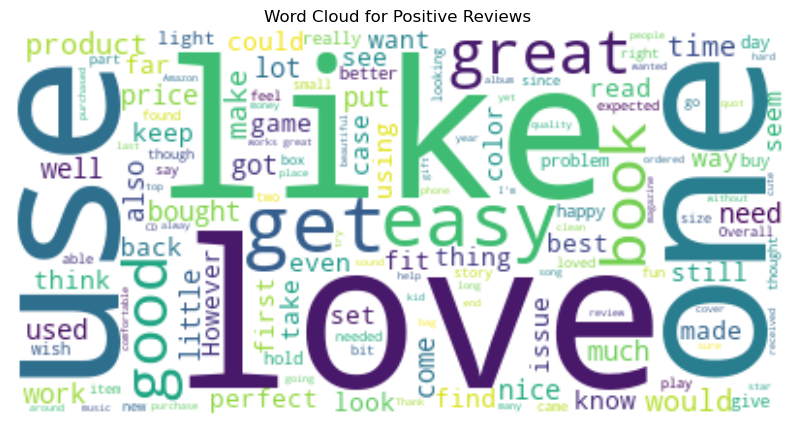

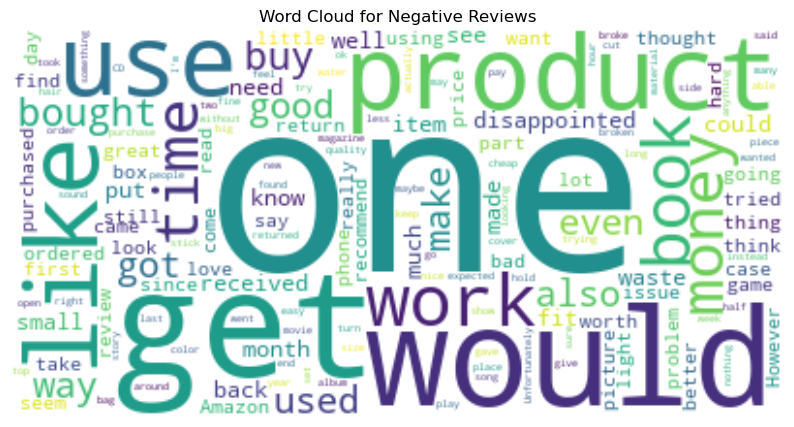

In [37]:
# 7. Word frequency analysis

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Adding br especially important because it exists in many reviews
custom_stop_words = {"br", "nbsp", "amp"} 
stop_words.update(custom_stop_words)

def generate_wordcloud(text, title):
    wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

positive_reviews = " ".join(df_reviews_raw[df_reviews_raw['rating'] >= 4]['text'])
negative_reviews = " ".join(df_reviews_raw[df_reviews_raw['rating'] <= 2]['text'])

generate_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')
generate_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')

In [38]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'br',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'nbsp',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'ou

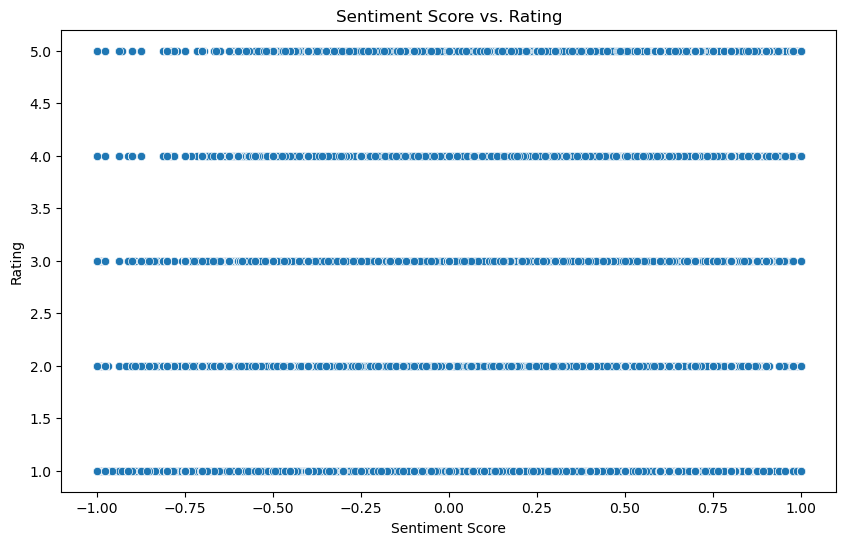

Correlation between sentiment score and rating: 0.49


In [39]:
# 8. Sentiment analysis

from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_reviews_raw['sentiment_score'] = df_reviews_raw['text'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_score', y='rating', data=df_reviews_raw)
plt.title('Sentiment Score vs. Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')
plt.show()

correlation = df_reviews_raw['sentiment_score'].corr(df_reviews_raw['rating'])
print(f"Correlation between sentiment score and rating: {correlation:.2f}")

TextBlob's sentiment polarity analysis works by assigning a sentiment score to a given text, ranging from -1 (very negative) to 1 (very positive). Here's an overview of how it functions:

1. Tokenization: The text is broken down into individual words or tokens[1].
2. Part-of-speech tagging: Each token is assigned a part-of-speech tag (e.g., noun, verb, adjective)[1].
3. Sentiment lexicon: TextBlob uses a pre-trained sentiment lexicon, which is a dictionary of words with associated sentiment scores[1].
4. Word scoring: Each word in the text is looked up in the sentiment lexicon to get its individual sentiment score[1].
5. Phrase analysis: TextBlob considers the context of words by analyzing phrases, not just individual words. This helps capture nuances like negations or intensifiers[1].
6. Aggregation: The individual word and phrase scores are combined to produce an overall sentiment score for the entire text[1].
7. Normalization: The final score is normalized to fall within the -1 to 1 range[1].
8. Subjectivity: In addition to polarity, TextBlob also provides a subjectivity score (0 to 1), indicating how subjective or objective the text is[1].

TextBlob's sentiment analysis is based on a simple averaging of word and phrase scores, which makes it fast and easy to use. However, it may not capture complex linguistic structures or context-dependent sentiments as effectively as more advanced machine learning models[1].

Citations:
[1] https://onlinetexttools.com/remove-words-from-text

In [40]:
from textblob import TextBlob

text = "I love this book! It's amazing."
blob = TextBlob(text)
polarity = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(f"Polarity: {polarity}")
print(f"Subjectivity: {subjectivity}")

Polarity: 0.6125
Subjectivity: 0.75


Percentage of reviews with images: 5.26%


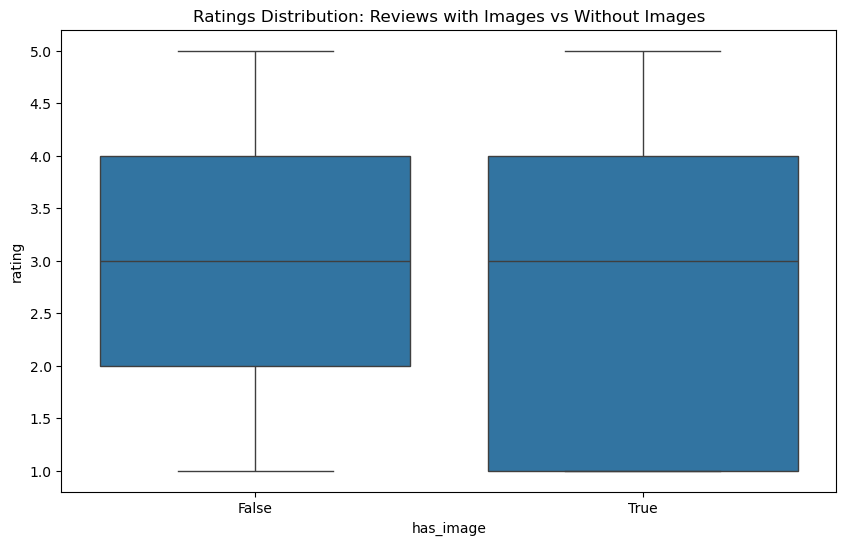

Average rating for reviews with images: 2.82
Average rating for reviews without images: 3.03


In [41]:
# 9. Image Analysis

image_percentage = (df_reviews_raw['has_image'].sum() / len(df_reviews_raw)) * 100
print(f"Percentage of reviews with images: {image_percentage:.2f}%")

plt.figure(figsize=(10, 6))
sns.boxplot(x='has_image', y='rating', data=df_reviews_raw)
plt.title('Ratings Distribution: Reviews with Images vs Without Images')
plt.show()

image_avg = df_reviews_raw[df_reviews_raw['has_image']]['rating'].mean()
no_image_avg = df_reviews_raw[~df_reviews_raw['has_image']]['rating'].mean()
print(f"Average rating for reviews with images: {image_avg:.2f}")
print(f"Average rating for reviews without images: {no_image_avg:.2f}")

In [42]:
df_reviews_raw.columns

Index(['asin', 'helpful_vote', 'parent_asin', 'rating', 'text', 'timestamp',
       'title', 'user_id', 'verified_purchase', 'category', 'has_image',
       'review_length', 'date', 'review_year', 'review_month',
       'sentiment_score'],
      dtype='object')

In [43]:
# Select columns you want to check correlation for
columns_to_check = ['review_length', 'helpful_vote', 'sentiment_score', 'rating']

correlation_matrix = df_reviews_raw[columns_to_check].corr()

print("Correlation matrix:")
print(correlation_matrix)

# Get correlation with rating specifically
rating_correlation = correlation_matrix['rating'].sort_values(ascending=False)

print("\nCorrelations with rating:")
print(rating_correlation)

Correlation matrix:
                 review_length  helpful_vote  sentiment_score    rating
review_length         1.000000      0.103290        -0.067404 -0.039294
helpful_vote          0.103290      1.000000        -0.016139 -0.025222
sentiment_score      -0.067404     -0.016139         1.000000  0.491281
rating               -0.039294     -0.025222         0.491281  1.000000

Correlations with rating:
rating             1.000000
sentiment_score    0.491281
helpful_vote      -0.025222
review_length     -0.039294
Name: rating, dtype: float64


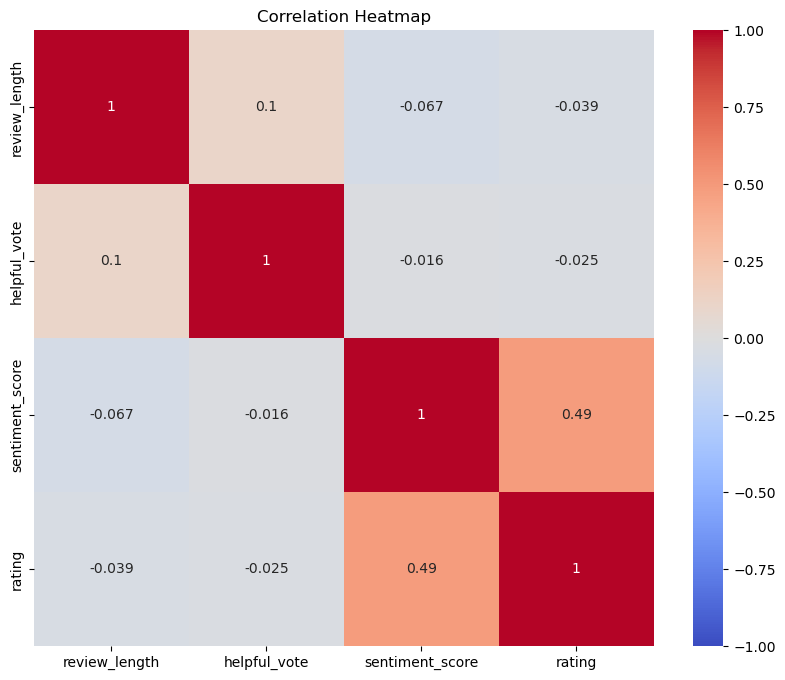

In [44]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

In [45]:
df_reviews_raw["text"]

0         Don’t get it!  My hair is falling out!  PLEASE...
1         The curved ends on almost all of these is not ...
2                                        Crappy & unusable.
3         Felt like a limp piece of cheap fabric. Have t...
4                                        Worst pain ever...
                                ...                        
952799    Love it I use it for Side quest hasn’t broke good
952800    I love the updated graphics a lot, and the new...
952801                                exactly what i wanted
952802    Best game closest to REAL-LIFE. I mostly race ...
952803                                                  Fun
Name: text, Length: 951769, dtype: object